In [49]:
!pip install -r requirements.txt

import av
import numpy as np
import skimage
from matplotlib import pyplot as plt

In [74]:
def load_frames(video_path):
    
    frames = []
    v = av.open(video_path)
    for packet in v.demux():
        for frame in packet.decode():
            img = frame.to_image()
            arr = np.asarray(img)
            frames.append(arr)
    return frames

In [79]:
def main():
    
    src_path = 'src/robot_parcours_1.avi'
    frames = load_frames(src_path)
    plt.imshow(frames[0])
    plt.show()

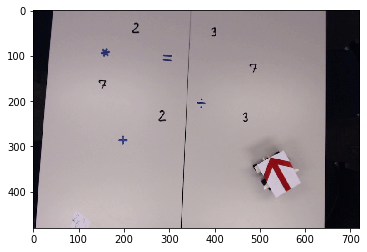

In [80]:
main()